# Part 3: Sentiment Analysis of Twitter feeds on US Airlines

### Abstract

This is part 3 of a series of projects to help me understand the real-life applications of Machine Learning. I will be trying to answer the question, "How do startup fintech companies provide sentiment based trading signals to investment professionals?".

#### Aim

There is a huge amount of information that a Chartered Financial Analyst needs to navigate through. Traditional methods of analysis needs to be augmented with state-of-the-art data science techniques. 

**How do startup companies provide sentiment based trading signals to investment professionals?**

To tackle this question, I will conduct several loosely related project workstreams: 
-  News classification - filtering general news articles to those related to 'Business'
-  Sentiment Analysis (postive or negative) - movie reviews and Twitter feeds. 
-  Applying Daily News to to predict Stock Market returns. 

These building blocks will be powerful components that I can adapt as a framework for use in future work related to Sentiment Analysis and NLP. 

## 3. Sentiment Analysis of Twitter Feeds on US Airlines

### 3.1 About the Dataset

CrowdFlower scraped Twitter data related to US Airline companies from February of 2015 and asked contributors to classify these as positive, negative, or neutral tweets. Negative tweets were then categorised further into various reasons, such as “late flight” or “rude service”.
-  [Airline Twitter Sentiment](https://www.crowdflower.com/data-for-everyone/)

This is a valuable dataset available publicly on which we can apply machine learning algorithms. As expected, proprietary datasets that require payment to access will likely provide information advantage.

### 3.1a Import modules and loading the data

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
# import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

# import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

Load in the data

In [2]:
tweets = pd.read_csv('C:/input/Tweets.csv')

## 3.2 Exploratory Data Analysis

In [3]:
tweets.shape

(14640, 15)

The dataset contains 14,640 tweets and 15 variables (columns).

In [4]:
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [5]:
tweets.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


To simulate application of sentiment analysis in real-life, we want to be able to determine the sentiment of a tweet without any other information but the tweet text itself. Therefore the 'text' column is our focus. In other words, using the 'text' column we are going to try and predict the 'airline_sentiment' column.

Lets check to see what data is missing.

In [6]:
#missing data
total = tweets.isnull().sum().sort_values(ascending=False)
percent = (tweets.isnull().sum()/tweets.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
negativereason_gold,14608,0.997814
airline_sentiment_gold,14600,0.997268
tweet_coord,13621,0.930396
negativereason,5462,0.373087
user_timezone,4820,0.329235
tweet_location,4733,0.323292
negativereason_confidence,4118,0.281284
tweet_created,0,0.000000
text,0,0.000000
retweet_count,0,0.000000


The missing data will not have any impact our sentiment analysis models.

### 3.2a Proportion of tweets within each sentiment

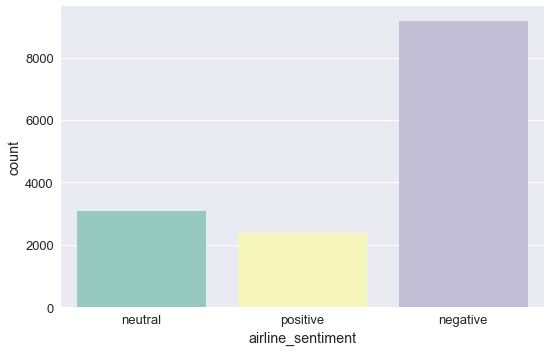

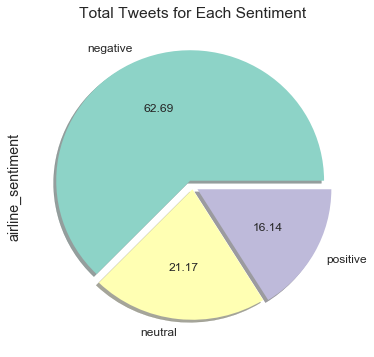

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

df = tweets[['text', 'airline_sentiment']]

sns.factorplot(x="airline_sentiment", data=df, kind="count", size=5, aspect=1.5, palette="Set3")
plt.show();

colors=sns.color_palette("Set3", 10)
pd.Series(tweets["airline_sentiment"]).value_counts().plot(kind="pie",colors=colors,
    labels=["negative", "neutral", "positive"],explode=[0.05,0.02,0.04],
    shadow=True,autopct='%.2f', fontsize=12,figsize=(6, 6),title = "Total Tweets for Each Sentiment")

We can see that negative tweets dominate this dataset. This is understandable as negative emotions are more powerful, and one immediate way to vent anger is by tweeting. 

When a customer pays for a service, there is a general expectation for a good experience. So in general a customer will only post a positive tweet if they have had an exceptionally happy experience, where the airline company has gone over and above their expectation.

### 3.2b Proportion of tweets directed towards each airline

Let's have a look at the proportion of tweets to see if we can gain any insight.

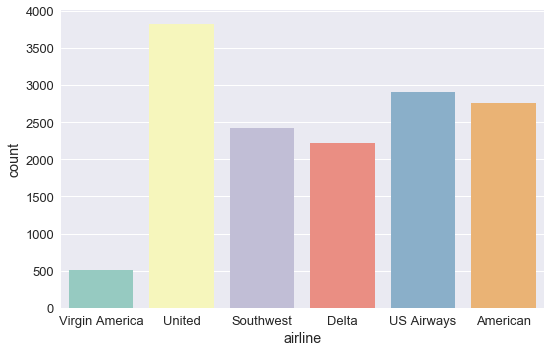

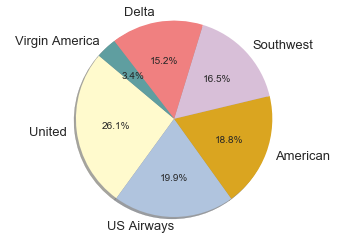

In [8]:
df = tweets[['text', 'airline']]

sns.factorplot(x="airline", data=df, kind="count", size=5, aspect=1.5, palette="Set3")
plt.show();

# Data to plot
labels = 'United','US Airways','American','Southwest', 'Delta', 'Virgin America'  
value = tweets['airline'].value_counts()
Un, US, Am, So, De, Vi = value[0], value[1], value[2], value[3], value[4], value[5]
proportion = [Un, US, Am, So, De, Vi]
colors = ['lemonchiffon', 'lightsteelblue', 'goldenrod', 'thistle', 'lightcoral', 'cadetblue']
explode = (0, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(proportion, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

-  Our expectation is that airlines flying more customers will have more tweets. 
However it seems like the smaller the airline the higher number of tweets.

Market Cap 
-  Delta(DAL): 40bn
-  Southwest(LUV): 35.47bn
-  American(AAL): 26.60bn
-  United(UAL): 20.67bn
-  US Airways: Merged with American Airlines in July 2015
-  Virgin: privately held so no ticker

** Side project: I need to automate scraping market cap values from a free source

In [9]:
import requests
from bs4 import BeautifulSoup

def get_cap(ticker):
    tick = ticker
    r = requests.get("http://www.zacks.com/stock/quote/", tick)
    soup = BeautifulSoup(r.content, "html.parser")
    for tr in soup.findAll("table", class_="abut_bottom"):
        for td in tr.find_all("td"):
            if td.text == "Market Cap":
                print(td.text, td.find_next_sibling("td").text)

In [10]:
get_cap('UAL')

Market Cap 884.23 B


### 3.2c Sentiment of tweets within each airline

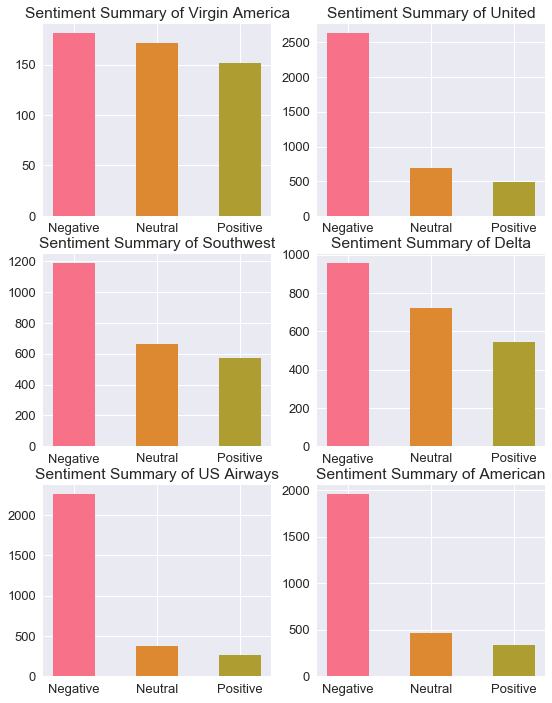

In [11]:
def plot_sub_sentiment(Airline):
    pdf = tweets[tweets['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("husl", 10)
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment Summary of' + " " + Airline)

airline_name = tweets['airline'].unique()
plt.figure(1,figsize=(9,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])

-  Across the various airlines the proportion of neutral and positive tweets are similar.
-  One thing that jumps out at us is that Virgin airlines has fewer negative tweets. I am based in the UK and unfamiliar with how the US airline business is segmented in terms of target customers and branding. Virgin airlines is a well known luxury brand in the UK that tries to differentiate itself on excellent customer services. So this result falls in line with my expectation. 
-  The 3 smaller airlines have higher negative tweets (United, US Airways and American). These airlines have less resources and therefore it seems reasonable that their strategy may be to minimise costs by provide a basic service with less thrills.

** Interpretation  **
-  If we split the airlines into 2 tiers - luxury and basic, then we would look for the airlines doing significantly better or worse than their peers. An airline that consistently gathers more negative tweets over a period of time (eg. 12 months) could see a drop in customers and a corresponding drop in revenue if issues are not addressed.
-  An analyst might be able to build into their equity valuation model a link between negative tweets, sales, turnover etc, and the impact on the company's annual results. In other words, a portfolio manager could extract alpha by choosing to hold an overweight position in the best-in-class.

### 3.2d Reasons for negative sentiment tweets

A question worth answering is which of these negative tweets are within the control of each airline. As opposed to general issues affecting all airlines such as weather, airport facilities, baggage handlers, etc.

Text(0,0.5,'No. of Tweets')

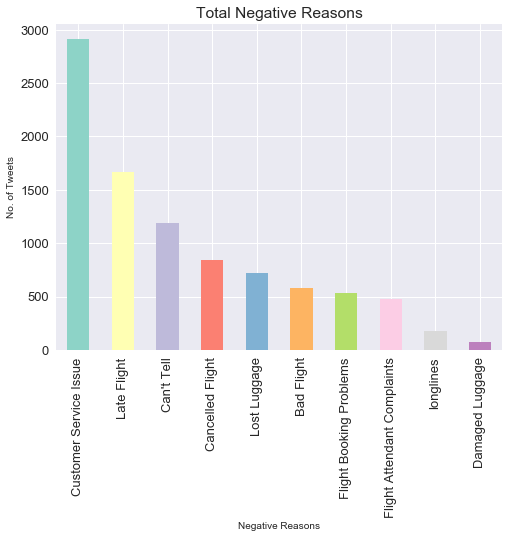

In [12]:
#Plotting all the negative reasons 
color=sns.color_palette("Set3", 10)
pd.Series(tweets["negativereason"]).value_counts().plot(kind = "bar",
                        color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

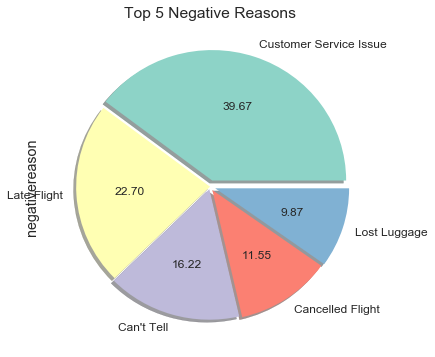

In [13]:
# Pie chart of top 5 negative reasons
color=sns.color_palette("Set3", 10)
pd.Series(tweets["negativereason"]).value_counts().head(5).plot(kind="pie",
                labels=["Customer Service Issue", "Late Flight", "Can't Tell","Cancelled Flight","Lost Luggage"],
                colors=color,autopct='%.2f',explode=[0.05,0,0.02,0.03,0.04],shadow=True,
                fontsize=12,figsize=(6, 6),title="Top 5 Negative Reasons")


These reasons can be addressed by the airline company and should be investigated further:
-  Customer service: more data should be obtained to work out what specific aspect of customer service causes the most grief. Lack of staff, lack of communication, unfriendly staff, lack of knowledge, etc.  
-  Bad flight: presumably the time spent in the air was a bad experience. Was this due to staff or other customers.
-  Flight attendant complaints.
-  Flight bookings: invest in a better system.
-  Long lines: is this due to staffing issues by the airport provider itself. Will having more airline staff help? 

These reasons are more likely to be attributed to the airport provider:
-  late flight
-  cancelled flight
-  lost luggage
-  damaged luggage. 

A portfolio manager of a global investment portfolio may choose to underweight an airport provider that consistently scores lower in comparison to peers.

### 3.2e Reasons for negative sentiment tweets within each Airline

In [14]:
NR_Count=dict(tweets['negativereason'].value_counts(sort=False))

def NR_Count(Airline):
    if Airline=='All':
        df=tweets
    else:
        df=tweets[tweets['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [15]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

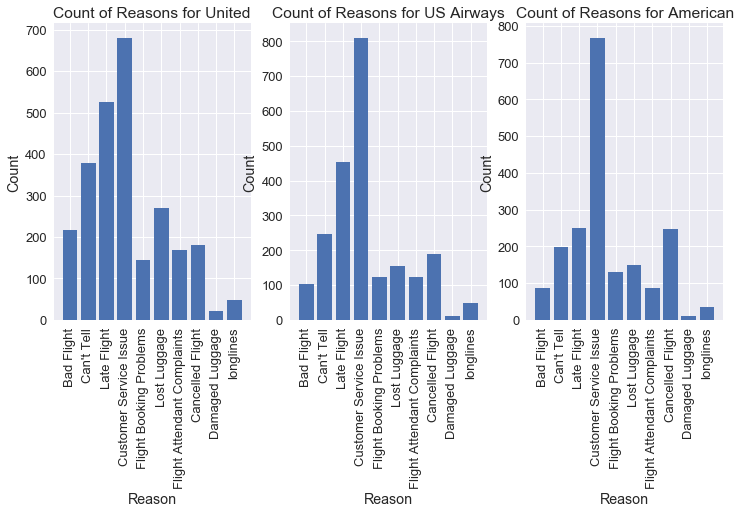

In [16]:
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_reason('United')
plt.subplot(232)
plot_reason('US Airways')
plt.subplot(233)
plot_reason('American')
plt.show()

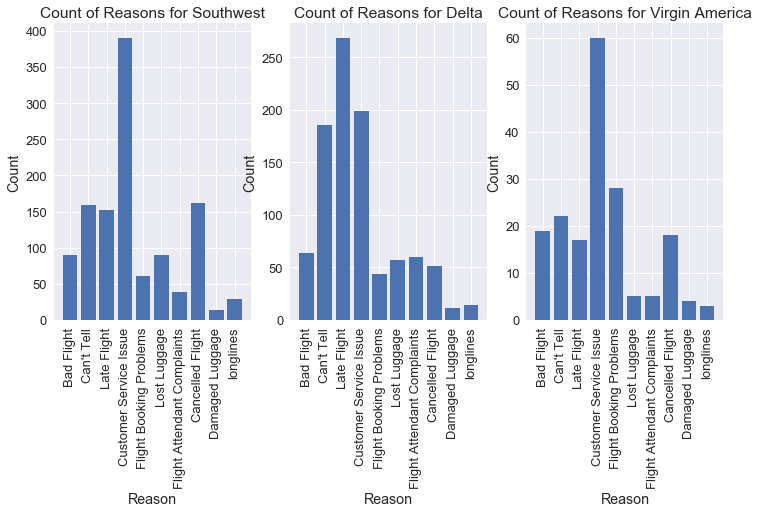

In [17]:
plt.figure(1,figsize=(12, 12))
plt.subplot(234)
plot_reason('Southwest')
plt.subplot(235)
plot_reason('Delta')
plt.subplot(236)
plot_reason('Virgin America')
plt.show()

Customer service issue remains the top negative reason across all airlines, apart from Delta.

Southwest and Delta are comparable due to thier market cap size. 
-  Southwest has higher customer service complaints and cancelled flights. Delta scores well apart from having a higher number of late flights. 

United, US Airways and American are comparable due to thier market cap size.
-  US Airways has the most customer service issues and more late flights. 
-  United had a lower amount of customer service issues but more late flights and bad flights.
-  American Airways scores between the other two airlines but does have a higher amount of cancelled flights. 

## 3.3 Visualising tweets on maps

The dataset has a column which represents the location the customer was based when they made the tweet. Lets see if this provides any insight. 

### 3.3a Plot coordinates on a Folium Map

We begin by cleaning the missing data from the coordinates column and processing it into a suitable format.

In [18]:
clean_coords = tweets
clean_coords["tweet_coord"] = clean_coords["tweet_coord"].fillna("None")

clean_coords.isnull().sum().sort_values(ascending=False)

negativereason_gold             14608
airline_sentiment_gold          14600
negativereason                  5462 
user_timezone                   4820 
tweet_location                  4733 
negativereason_confidence       4118 
tweet_created                   0    
tweet_coord                     0    
text                            0    
retweet_count                   0    
name                            0    
airline                         0    
airline_sentiment_confidence    0    
airline_sentiment               0    
tweet_id                        0    
dtype: int64

In [19]:
geo_df = clean_coords["tweet_coord"]
geo_df = list(filter(lambda a: a != "None", geo_df))

In [20]:
print(geo_df[0:4])

['[40.74804263, -73.99295302]', '[42.361016, -71.02000488]', '[33.94540417, -118.4062472]', '[33.94209449, -118.40410103]']


Split tweet coordinates into Latitude and Longitude

In [21]:
lat, long = zip(*(s.split(",") for s in geo_df))

In [22]:
print(lat[0:4])
print(long[0:4])

('[40.74804263', '[42.361016', '[33.94540417', '[33.94209449')
(' -73.99295302]', ' -71.02000488]', ' -118.4062472]', ' -118.40410103]')


Remove the [ and ] brackets

In [23]:
def remove_char(s):
    return s[1:]
lat = [remove_char(s) for s in lat]
def remove_char(t):
    return t[1:-1]
long = [remove_char(t) for t in long]

In [24]:
print(lat[0:4])
print(long[0:4])

['40.74804263', '42.361016', '33.94540417', '33.94209449']
['-73.99295302', '-71.02000488', '-118.4062472', '-118.40410103']


In [25]:
len(lat)
len(long)

1019

In [26]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

### 3.3b Where are the tweets from around the world?

In [27]:
map1 = folium.Map(location=[40, 0], tiles='Stamen Terrain', zoom_start=1.4)
marker_cluster = MarkerCluster().add_to(map1)
for point in range(0, len(long)):
    folium.Marker(location=[float(lat[point]), float(long[point])]).add_to(marker_cluster)
map1

-  Of the 14,640 tweets there are 1019 tagged with 'coordinates'. 
-  Plotting these on a map we can see that the majority of tweets are located within North America which makes sense.
-  There are 164 tweets located in the ocean below central Africa, presumably these are not valid coordinates and should be ignored/removed.
-  The rest of the tweets are located at the customers' arrivals destination outside of the US.

### 3.3c Tweets across the US

In [28]:
map2 = folium.Map(location=[37, -99], tiles='CartoDB positron', zoom_start=3.5)
marker_cluster = MarkerCluster().add_to(map2)
for point in range(0, len(long)):
    folium.Marker(location=[float(lat[point]), float(long[point])]).add_to(marker_cluster)
map2

There are more tweets coming from the east coast. This could just be down to higher population size or more flight routes on offer. We need additional information to draw any useful insight.

### 3.3d Tweets around the New York region

In [29]:
map3 = folium.Map(location=[40.74804263, -73.99295302], zoom_start=8.5)
marker_cluster = MarkerCluster().add_to(map3)
for point in range(0, len(long)):
    folium.Marker(location=[float(lat[point]), float(long[point])]).add_to(marker_cluster)
map3

It makes sense that the tweets are located near major airports.

### 3.3e Tweets at JFK airport

In [30]:
map4 = folium.Map(location=[40.645, -73.785], zoom_start=15)
marker_cluster = MarkerCluster().add_to(map4)
for point in range(0, len(long)):
    folium.Marker(location=[float(lat[point]), float(long[point])]).add_to(marker_cluster)
map4

The tweets tend to occur near arrivals which suggest people tweeting shortly after landing.

## 3.4 Preprocess data for classification

We now have enough insight into the data to start building the machine learning models. The aim here is to just implement a wide range of models to gain intuition rather than tuning the hyperparameters to achieve a good score. Practice across different models will having a greater positive impact on my personal development at this stage of my learning.

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.metrics import log_loss

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [32]:
df = tweets[['text', 'airline_sentiment']]

We define this as a multiclass classification problem by converting the written sentiment into numbers.

In [33]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
y = tweets.airline_sentiment.apply(sentiment2target)

The dataset is quite small and therefore we will want to use the largest possible training set. I will assume that holding out a 10% test set will be sufficient if combined with cross validation. There is a chance of overfitting on a small training set so I am choosing 5-fold cross validation over 10-fold. We want the train and test sets to be split randomly but by specifying the random_state as '42' we can replicate the results on future runs.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(tweets.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [35]:
print (x_train.shape)
print (x_test.shape)

(13176,)
(1464,)


## 3.5 Building Basic Models

Our very first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) using a simple Logistic Regression.

### 3.5a TF-IDF, Logistic Regression (79.1%)

In [36]:
%%time
# These features work well on most NLP problems.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(x_train) + list(x_test))
x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

Wall time: 3.57 s


In [37]:
%%time
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(x_train_tfv, y_train)
predictions = clf.predict_proba(x_test_tfv)

Wall time: 354 ms


In [38]:
%%time
from sklearn.model_selection import cross_val_score
results_clf_cv = cross_val_score(clf, x_train_tfv, y_train, cv=5)
print(results_clf_cv.mean())

0.7681374376911247
Wall time: 1.2 s


In [39]:
clf.score(x_test_tfv, y_test)

0.7909836065573771

This is a very good baseline model. 

** Accuaracy of 79.1% against the test set. ** 
While 5-fold cross validation is 76.8%.

A more appropriate metric would be multiclass log loss. I need to study more here as I am not convinced this is working correctly. Something to do in the next project. (This is where I would benefit from having access to a mentor).

In [40]:
from sklearn.metrics import log_loss

In [41]:
print ("logloss: %0.3f " % log_loss(y_test, predictions))

logloss: 0.555 


### 3.5b TF-IDF, OneVsRest Classifier (72.8%)

In [42]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [43]:
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
%time clf_output = clf.fit(x_train_tfv, y_train)

Wall time: 6min 34s


In [44]:
%%time
results_clf_cv = cross_val_score(clf, x_train_tfv, y_train, cv=5)
print(results_clf_cv.mean())

0.7188811588855295
Wall time: 14min 52s


In [45]:
clf.score(x_test_tfv, y_test)

0.7281420765027322

** Accuracy of 72.8%. ** So not an improvement on logistic regression. 

### 3.5c Word Count, Logistic Regression (80%)

Instead of using TF-IDF, we can also use word counts as features. This can be done using CountVectorizer from scikit-learn.

In [46]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets
ctv.fit(list(x_train) + list(x_test))
x_train_ctv =  ctv.transform(x_train) 
x_test_ctv = ctv.transform(x_test)

In [47]:
%%time
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(x_train_ctv, y_train)
predictions = clf.predict_proba(x_test_ctv)

Wall time: 4.22 s


In [48]:
%%time
results_clf_cv = cross_val_score(clf, x_train_ctv, y_train, cv=5)
print(results_clf_cv.mean())

0.7805085488385437
Wall time: 23.3 s


In [49]:
clf.score(x_test_ctv, y_test)

0.799863387978142

** Accuracy of 80% makes this the best model. **

In [50]:
print ("logloss: %0.3f " % log_loss(y_test, predictions))

logloss: 0.500 


### 3.5d Word Counts, Multinomial Naive Bayes (73%)

In [51]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(x_train_ctv, y_train)
predictions = clf.predict_proba(x_test_ctv)

In [52]:
%%time
results_clf_cv = cross_val_score(clf, x_train_ctv, y_train, cv=5)
print(results_clf_cv.mean())

0.7496197873449166
Wall time: 592 ms


In [53]:
print(clf.score(x_test_ctv, y_test))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

0.730191256830601
logloss: 1.077 


** Accuracy of 73% **

### 3.5e Singular Value Decomposition (75.6%)

In [54]:
%%time
# Apply SVD, I chose 120 components. From my research 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(x_train_tfv)
x_train_svd = svd.transform(x_train_tfv)
x_test_svd = svd.transform(x_test_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(x_train_svd)
x_train_svd_scl = scl.transform(x_train_svd)
x_test_svd_scl = scl.transform(x_test_svd)

Wall time: 3.23 s


Now it's time to apply SVM. Will take a while

In [55]:
%%time
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(x_train_svd_scl, y_train)
predictions = clf.predict_proba(x_test_svd_scl)

Wall time: 4min 32s


In [56]:
%%time
results_clf_cv = cross_val_score(clf, x_train_svd_scl, y_train, cv=5)
print(results_clf_cv.mean())

0.6268974397516214
Wall time: 6min 20s


In [57]:
print(clf.score(x_test_svd_scl, y_test))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

0.7561475409836066
logloss: 0.598 


** Accuracy of 75.6% **

### 3.5f XGBoost (76.4%)

Before moving further, lets apply xgboost.

In [58]:
%%time
# Fitting a simple xgboost on tf-idf Vectorizer
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(x_train_tfv.tocsc(), y_train)
predictions = clf.predict_proba(x_test_tfv.tocsc())

Wall time: 17.5 s


In [62]:
print(clf.score(x_test_tfv.tocsc(), y_test))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

0.764344262295082
logloss: 0.566 


** Accuracy of 76.4% **

### 3.5g GloVe Word Vectors

In one of my previous projects I went through word embeddings use Word2Vec and Stanford GloVe.

In [64]:
%%time
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open("C:/Python Project Files/glove.840B.300d.txt", encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [09:09, 3995.72it/s]


Found 2195885 word vectors.
Wall time: 9min 9s


In [65]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [66]:
# create sentence vectors using the above function for training and validation set
x_train_glove = [sent2vec(x) for x in tqdm(x_train)]
x_test_glove = [sent2vec(x) for x in tqdm(x_test)]

print('Normalized Vector for Sentences have been created')

100%|██████████| 1464/1464 [00:02<00:00, 626.99it/s]


Normalized Vector for Sentences have been created


In [67]:
x_train_glove = np.array(x_train_glove)
x_test_glove = np.array(x_test_glove)

Let's see the performance of xgboost on glove features:

### 3.5h XGBoost on GloVe features (78.6%)

In [68]:
%%time
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(x_train_glove, y_train)
predictions = clf.predict_proba(x_test_glove)

Wall time: 37.1 s


In [69]:
%%time
results_clf_cv = cross_val_score(clf, x_train_glove, y_train, cv=5)
print(results_clf_cv.mean())

0.7700365553184956
Wall time: 2min 9s


In [70]:
print(clf.score(x_test_glove, y_test))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

0.773224043715847
logloss: 0.570 


In [71]:
%%time
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(x_train_glove, y_train)
predictions = clf.predict_proba(x_test_glove)

Wall time: 1min 56s


In [72]:
%%time
results_clf_cv = cross_val_score(clf, x_train_glove, y_train, cv=5)
print(results_clf_cv.mean())

0.7802818529762465
Wall time: 7min 36s


In [73]:
print(clf.score(x_test_glove, y_test))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

0.7862021857923497
logloss: 0.563 


** Accuracy of 78.6% **

## 3.6 Deep Learning

In an era of deep learning we should train a few neural networks. Let's start with the dense network first.

In [74]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
x_train_glove_scl = scl.fit_transform(x_train_glove)
x_test_glove_scl = scl.transform(x_test_glove)

In [75]:
# we need to binarize the labels for the neural net
y_train_enc = np_utils.to_categorical(y_train)
y_test_enc = np_utils.to_categorical(y_test)

### 3.6a Sequential model (3 layers) using GloVe embeddings

Create 3 layer, sequential model:
-  1st layer has 12 neurons and expects 300 input variables
-  2nd layer has 8 neurons
-  Final output layer has 3 neurons
-  Most recent research has shown that the Rectified Linear Unit (ReLu) function provides the best results compared to sigmoid and tanh. Similarly the Adam optimiser is widely preferred over others. 

In [76]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(12, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [77]:
%%time
model.fit(x_train_glove_scl, y=y_train_enc, batch_size=10, 
          epochs=5, verbose=1, 
          validation_data=(x_test_glove_scl, y_test_enc))

Train on 13176 samples, validate on 1464 samples
Epoch 1/5
13176/13176 [==============================] - 987s 75ms/step - loss: 0.8607 - val_loss: 0.6544
Epoch 2/5
13176/13176 [==============================] - 988s 75ms/step - loss: 0.7138 - val_loss: 0.6162
Epoch 3/5
13176/13176 [==============================] - 991s 75ms/step - loss: 0.6918 - val_loss: 0.5967
Epoch 4/5
13176/13176 [==============================] - 993s 75ms/step - loss: 0.6885 - val_loss: 0.5826
Epoch 5/5
13176/13176 [==============================] - 995s 76ms/step - loss: 0.6614 - val_loss: 0.5781
Wall time: 1h 24min 31s


This has taken a long time to train on my CPU only machine.

In [78]:
predictions = model.predict_proba(x_test_glove_scl)
# print(model.score(x_test_glove_scl, y_test_enc))
print ("logloss: %0.3f " % log_loss(y_test, predictions))

logloss: 0.578 


In [79]:
# calculate predictions
predictions = model.predict(x_test_glove_scl)

Let's output the model predictions for fun. 

In [80]:
# round predictions
rounded = [round(x[0]) for x in predictions]
print(rounded)

[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,

It has taken a long time to train the model so it is a good idea to save the model for future use.

In [81]:
import pickle

# save the model to disk
filename = 'Airline_seq.sav'
pickle.dump(model, open(filename, 'wb'))

In [82]:
import pickle

# some time later...
# load the model from disk
filename = 'Airline_seq.sav'
model = pickle.load(open(filename, 'rb'))

### 3.6b RNN - LSTM using GloVe embeddings

To move further with LSTMs we need to tokenize the text data

In [83]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(x_train) + list(x_test))
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

In [84]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 15768/15768 [00:24<00:00, 653.87it/s]


In [85]:
%%time
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(12, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

Wall time: 5min 56s


In [86]:
%%time
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(x_train_pad, y=y_train_enc, batch_size=10, epochs=2, 
          verbose=1, validation_data=(x_test_pad, y_test_enc), callbacks=[earlystop])

Train on 13176 samples, validate on 1464 samples
Epoch 1/2
13176/13176 [==============================] - 15584s 1s/step - loss: 0.9023 - val_loss: 0.7098
Epoch 2/2
13176/13176 [==============================] - 14835s 1s/step - loss: 0.7829 - val_loss: 0.6392
Wall time: 8h 27min 13s


I had to run this overnight. It has taken over 8 hours to train.

In [87]:
# save the model to disk
filename = 'Airline_lstm_glove.sav'
pickle.dump(model, open(filename, 'wb'))

In [88]:
# some time later...
# load the model from disk
filename = 'Airline_lstm_glove.sav'
model = pickle.load(open(filename, 'rb'))

### 3.6c RNN - GRU using GloVe embeddings

In [89]:
%%time
# GRU with glove embeddings and one dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(12, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(12, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

Wall time: 5min 47s


In [90]:
%%time
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(x_train_pad, y=y_train_enc, batch_size=10, epochs=2, 
          verbose=1, validation_data=(x_test_pad, y_test_enc), callbacks=[earlystop])

Train on 13176 samples, validate on 1464 samples
Epoch 1/2
13176/13176 [==============================] - 16835s 1s/step - loss: 0.8866 - val_loss: 0.7118
Epoch 2/2
13176/13176 [==============================] - 17762s 1s/step - loss: 0.7879 - val_loss: 0.6999
Wall time: 9h 36min 53s


In [91]:
# save the model to disk
filename = 'Airline_gru.sav'
pickle.dump(model, open(filename, 'wb'))

In [92]:
# some time later...
# load the model from disk
filename = 'Airline_gru.sav'
model = pickle.load(open(filename, 'rb'))

It is possible to improve performance by optimising further. Other aspects worth trying are stemming and lemmatisation which I will carry out in another future project. 

CPU processing is only useful for shallow learning.
For deep learning I need to pay for cloud computing power in the form of Amazon Web Services or Google Cloud Platform.

In the meantime, I need to find a stable solution to utilise my AMD graphic card with Tensorflow as it is currently not supported.

## 3.7 Lessons I have learnt from this project

This project took me longer to complete than expected. The main aspect that held me up was training the deep learning models. I have learnt a huge amount. Overall it has been very successful project that has been beneficial for my development. 

New tools added to skillset:
-  Folium
-  Recurrant Neural Networks: LSTM & GRU

Practised:
-  Visualistion: seaborn, matplotlib
-  train_test_split
-  TF-IDF, GloVe word embeddings
-  Shallow learning: Logistic Regression, SVM, Multinomial NB, XGBoost
-  Deep learning